In [1]:
import os
import tensorflow as tf
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Input
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
import math

from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, HTML
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
import pandas as pd

from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [5]:
train_data_dir = r'W:/RAFDB/RAFDB/train/'
validation_data_dir = r'W:/RAFDB/RAFDB/val/'

In [6]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
CHANNELS = 3
num_classes = 7

batch_size=32*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)
class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [7]:
# Init the Image Data Generator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Train Images
train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
)

# Validation images (From Train Images)
validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'
)

Found 10733 images belonging to 7 classes.
Found 4606 images belonging to 7 classes.


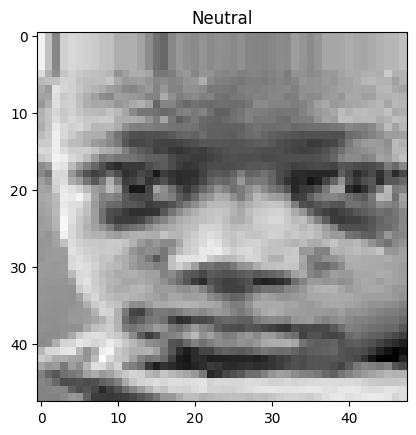

In [8]:
img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [9]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(pd.concat([train_count, test_count], axis=0).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,606,613,248,4169,2242,1722,1133
test,261,264,107,1788,962,738,486


In [10]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

10733
4606


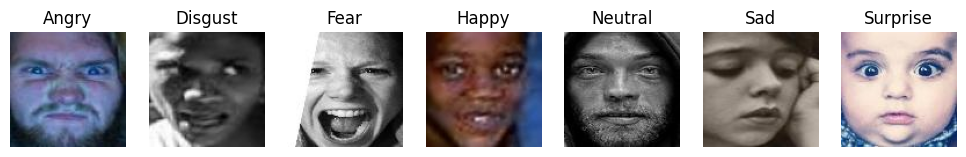

In [11]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_data_dir):
    img_file = random.choice(os.listdir(train_data_dir + expression))
    img = load_img(os.path.join(train_data_dir, expression, img_file))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [12]:
# def conv2d_same(inputs, filters, kernel_size, strides=1, name=None):
#     if strides == 1:
#         return Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False, name=name)(inputs)
#     else:
#         pad_total = kernel_size - 1
#         pad_beg = pad_total // 2
#         pad_end = pad_total - pad_beg
#         inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end], [pad_beg, pad_end], [0, 0]])
#         return Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='valid', use_bias=False, name=name)(inputs)

# def batchnorm(inputs, momentum=0.1, epsilon=0.001, name=None):
#     return BatchNormalization(momentum=momentum, epsilon=epsilon, name=name)(inputs)

# def activation(inputs, name=None):
#     return Activation('swish', name=name)(inputs)

# def squeeze_excite(inputs, filters, name=None):
#     se = tf.reduce_mean(inputs, [1, 2], keepdims=True)
#     se = Conv2D(filters=filters // 4, kernel_size=1, activation='swish', name=name + '_conv_reduce')(se)
#     se = Conv2D(filters=filters, kernel_size=1, activation='sigmoid', name=name + '_conv_expand')(se)
#     return Multiply(name=name + '_scale')([inputs, se])

# def inverted_residual_block(inputs, filters, expand_ratio, stride, block_id):
#     prefix = 'block_{}_'.format(block_id)
#     in_channels = inputs.shape[-1]
#     pointwise_filters = int(filters * expand_ratio)

#     x = conv2d_same(inputs, pointwise_filters, 1, name=prefix + 'conv_pw')
#     x = batchnorm(x, name=prefix + 'bn1')
#     x = activation(x, name=prefix + 'act1')

#     x = conv2d_same(x, pointwise_filters, 3, strides=stride, name=prefix + 'conv_dw')
#     x = batchnorm(x, name=prefix + 'bn2')
#     x = activation(x, name=prefix + 'act2')

#     x = squeeze_excite(x, pointwise_filters, name=prefix + 'se')

#     x = conv2d_same(x, filters, 1, name=prefix + 'conv_pwl')
#     x = batchnorm(x, name=prefix + 'bn3')

#     if stride == 1 and in_channels == filters:
#         x = Add(name=prefix + 'add')([inputs, x])
#     return x

# def build_efficientnet(input_shape, num_classes):
#     inputs = tf.keras.Input(shape=input_shape)

#     x = conv2d_same(inputs, 32, 3, strides=2, name='conv_stem')
#     x = batchnorm(x, name='bn1')
#     x = activation(x, name='act1')

#     x = inverted_residual_block(x, 16, 1, 1, block_id=0)
#     x = inverted_residual_block(x, 24, 6, 2, block_id=1)
#     x = inverted_residual_block(x, 40, 6, 2, block_id=2)
#     x = inverted_residual_block(x, 80, 6, 2, block_id=3)
#     x = inverted_residual_block(x, 112, 6, 1, block_id=4)
#     x = inverted_residual_block(x, 192, 6, 2, block_id=5)
#     x = inverted_residual_block(x, 320, 6, 1, block_id=6)

#     x = conv2d_same(x, 1280, 1, name='conv_head')
#     x = batchnorm(x, name='bn2')
#     x = activation(x, name='act2')

#     x = GlobalAveragePooling2D(name='avg_pool')(x)
#     outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     return model

In [28]:
from tensorflow.keras import layers, models


def mlp_block(x, hidden_dim, drop_rate):
    x = layers.Dense(hidden_dim)(x)
    x = layers.Activation(tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(x.shape[-1])(x)
    x = layers.Dropout(drop_rate)(x)
    return x


def attention_block(x, embed_dim, num_heads, attn_drop_rate, proj_drop_rate):
    qkv_dim = embed_dim // num_heads
    x = layers.Dense(3 * embed_dim, use_bias=False)(x)
    x = layers.Reshape((-1, num_heads, qkv_dim))(x)
    x = layers.Permute((2, 1, 3))(x)
    x = layers.Reshape((-1, x.shape[2] * x.shape[3]))(x)
    x = tf.split(x, num_or_size_splits=3, axis=2)
    q, k, v = x

    attn = tf.matmul(q, k, transpose_b=True)
    attn = attn / tf.math.sqrt(tf.cast(qkv_dim, dtype=tf.float32))
    attn = layers.Softmax()(attn)
    attn = layers.Dropout(attn_drop_rate)(attn)

    x = tf.matmul(attn, v)
    x = layers.Reshape((-1, num_heads * qkv_dim))(x)
    x = layers.Dense(embed_dim)(x)
    x = layers.Dropout(proj_drop_rate)(x)
    return x


def vit_model(img_size, patch_size, num_classes, depth, embed_dim, num_heads,
              mlp_ratio, attn_drop_rate, proj_drop_rate, drop_path_rate):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = inputs

    x = patch_embed(x, embed_dim)
    cls_token = tf.Variable(tf.zeros((1, 1, embed_dim)))
    cls_token = tf.tile(cls_token, [tf.shape(x)[0], 1, 1])
    x = layers.Concatenate(axis=1)([cls_token, x])
    x = layers.Dropout(proj_drop_rate)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    for _ in range(depth):
        x = attention_block(x, embed_dim, num_heads, attn_drop_rate, proj_drop_rate)
        x = x + layers.Dropout(drop_path_rate)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = mlp_block(x, int(embed_dim * mlp_ratio), proj_drop_rate)

    cls_token = x[:, 0]
    outputs = layers.Dense(num_classes, activation='softmax')(cls_token)

    model = models.Model(inputs, outputs)
    return model

In [29]:
# Open the strategy scope
with strategy.scope():

    # Define the model
    model = vit_model(
        img_size=48,
        patch_size=16,
        num_classes=7,  # Number of output classes
        depth=6,
        embed_dim=768,
        num_heads=8,
        mlp_ratio=4.0,
        attn_drop_rate=0.0,
        proj_drop_rate=0.0,
        drop_path_rate=0.1
    )


    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Save the model architecture diagram as a PNG file
# plot_model(model, to_file='efficientnet_architecture.png', show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 48, 48, 768)  2304        ['input_7[0][0]']                
                                                                                                  
 reshape_114 (Reshape)          (None, 2304, 768)    0           ['conv2d_6[0][0]']               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['reshape_114[0][0]']            
 )                                                                                          

In [30]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [31]:
# Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=400,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/400
INFO:tensorflow:batch_all_reduce: 59 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 59 all-reduces with algorithm = hierarchical_copy, num_packs = 1


ResourceExhaustedError: Graph execution error:

Detected at node 'model_4/dense_153/Tensordot/MatMul' defined at (most recent call last):
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\threading.py", line 937, in _bootstrap
      self._bootstrap_inner()
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\threading.py", line 980, in _bootstrap_inner
      self.run()
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\layers\core\dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'model_4/dense_153/Tensordot/MatMul'
Detected at node 'model_4/dense_153/Tensordot/MatMul' defined at (most recent call last):
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\threading.py", line 937, in _bootstrap
      self._bootstrap_inner()
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\threading.py", line 980, in _bootstrap_inner
      self.run()
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\layers\core\dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'model_4/dense_153/Tensordot/MatMul'
Detected at node 'model_4/dense_153/Tensordot/MatMul' defined at (most recent call last):
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\threading.py", line 937, in _bootstrap
      self._bootstrap_inner()
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\threading.py", line 980, in _bootstrap_inner
      self.run()
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\keras\layers\core\dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'model_4/dense_153/Tensordot/MatMul'
3 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[73760,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/dense_153/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[div_no_nan_1/_559]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[73760,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/dense_153/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[div_no_nan_1/ReadVariableOp_3/_544]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (2) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[73760,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/dense_153/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_61202]

In [ ]:
save_model = model.save('EfficientNet_2.h5')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = load_model('RESNET18_Ultimate8.h5')
model.summary()

In [ ]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Model Evaluation

In [ ]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


In [ ]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


In [ ]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_generator)
test_evaluation = model.evaluate(validation_generator)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions for all validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate top 1 accuracy
top1_accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Top 1 Accuracy: {top1_accuracy:.2f}%")

# Calculate top 2 accuracy
top2_predictions = np.argsort(model.predict(test_img), axis=1)[:, -2:]
top2_accuracy = np.mean([1 if true_label in pred_labels else 0 for true_label, pred_labels in zip(y_true, top2_predictions)]) * 100
print(f"Top 2 Accuracy: {top2_accuracy:.2f}%")

# Calculate loss
loss = model.evaluate(test_img, test_lbl)[0]
print(f"Loss: {loss}")

# Calculate precision
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-Score: {f1:.2f}")


# Unseen batch

In [ ]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [ ]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

In [ ]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [ ]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


# Accuracy global and per class

In [ ]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

In [ ]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with Images

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('RESNET18_Real_12.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Fine Tunning

In [ ]:
with strategy.scope():

    model = load_model('best_model.h5')
    
    # # Load the VGG19 model
    # base_model = VGG16(
    #     weights='imagenet', 
    #     include_top=False, 
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the layers
    for layer in model.layers:
        layer.trainable = True
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    # inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # x = base_model(inputs)
    # x = Flatten()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = Dense(128, activation='relu')(x) 
    # predictions = Dense(7, activation='softmax')(x)

    # # Compile the model
    # model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

In [ ]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [ ]:
    # Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=200,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

In [ ]:
save_model = model.save('VGG16_VGGFACE_100e_TF_FT_FER.h5')

# Fine Tunning model evaluation

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


In [ ]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


In [ ]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen batch

In [ ]:
model = load_model("VGG16_VGGFACE_100e_TF_FT_FER.h5")

In [ ]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [ ]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

In [ ]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [ ]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


# Accuracy global and per class

In [ ]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

In [ ]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test it with real images

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
model = load_model('best_model.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
